# Project 2 report

### Author: Chen Tao,  Shuting Zhang,  Yuying Zhang,  Ziyue Zhao

This report mainly explains how to perform data analysis, including not only importing data into Python, tidying up the data, designing problems according to the nature of the data, but also how to write code to achieve our goal and how to analyze the output results. This report focuses on Scotland road traffic data, which include the number of different types of vehicles driving on all given roads from 7 a.m. to 6 p.m. on working days from March to October each year from 2000 to 2019. We conducted a detailed analysis on these data. First, we explored some properties of each road, and then we output some graph results to study the traffic flow of each road, including the comparison of the total number of vehicles on each road, the changes in the number of vehicles over the years, and the changes in vehicles on the time of the day. We also conduct detailed research on a road, and in-depth exploration of the geographic location of each road. Finally it is worth mentioning that this report uses a lot of visualization methods to help us feel the connotation of the data more intuitively.

## 1. Data preparation

### 1.1 Import packages

We firstly import some Python packages that will be used in this project.

Also, for the visualization about the maps, we need to install the package `folium` of Python. You can choose one of the methods below to install this package.  
1. Type "pip install folium" in Anaconda Prompt or Command Prompt (CMD) (for Window system)  
2. Type "conda install --channel https://conda.anaconda.org/beautah folium" in Anaconda Prompt (for Window system)

In [1]:
# Set up - Import all the packages used in this project
import csv
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import time
# Set Seaborn style of plotting
sns.set()

# Import the package that is used to create maps
import folium
from folium import plugins

### 1.2 Raw data processing

Then, we need to load the traffic data. For this data set, we first open the `csv` file and read it, and convert the raw data to `pandas` dataframe. After that, the subsequent process involves marking missing values of the data, converting the types of some columns and purifying the data.

In [2]:
# Load the traffic data
data = []
# Because the items in the file 'dft_rawcount_region_id_3.csv' may also contain commas ',' the functions loadtext() or read_csv() etc in the Numpy or Pandas module cannot be directly used.
f = open('dft_rawcount_region_id_3.csv', "r")
reader = csv.reader(f, delimiter = ',')
for row in reader:
    data.append(row)
f.close()
data = np.array(data)
data = pd.DataFrame(data[1:, :], columns = data[0])

# Mark the missing values of the data
for item in ['start_junction_road_name', 'end_junction_road_name', 'link_length_km', 'link_length_miles']:
    data.loc[data[item] == '', item] = np.nan

# Necessarily convert some columns of the dataframe to numeric type in order to perform data analysis
data[['easting', 'northing']] = data[['easting', 'northing']].astype('int')
data[['pedal_cycles', 'two_wheeled_motor_vehicles', 'cars_and_taxis', 'buses_and_coaches', 'lgvs', 'hgvs_2_rigid_axle', 'hgvs_3_rigid_axle', 'hgvs_3_or_4_articulated_axle', 'hgvs_4_or_more_rigid_axle', 'hgvs_5_articulated_axle', 'hgvs_6_articulated_axle', 'all_hgvs', 'all_motor_vehicles']] = data.loc[:, 'pedal_cycles':'all_motor_vehicles'].astype('int')
data[['latitude', 'longitude', 'link_length_km', 'link_length_miles']] = data.loc[:, 'latitude':'link_length_miles'].astype('float')

# Purify the data set
# Because we discover that there are some repeated data in this data set where the latitude and longitude of these data are rounded to integers, with all the other information remained, we should remove these duplicated data
data = data.loc[(data['latitude'] % 1 != 0) | (data['longitude'] % 1 != 0), :]

## 2. Road basic information statistics

### 2.1 Road management

We select two columns "local_authority_name" and "road_name", and we delete the duplicated rows in order to obtain the distinct roads that local authrities manage. Finally, we find that Highland is the one that manage the most number of different roads.

In [3]:
data.loc[:, ['local_authority_name', 'road_name']].drop_duplicates().groupby('local_authority_name').count().sort_values(by = 'road_name', ascending = False).head(1)

road_name
local_authority_name           
Highland                     65

### 2.2 The length of the roads

In this part, we calculate the length of every major road. Because the lengths of minor roads are not recorded, we should ignore them and only focus on the major roads. From the output, we can see that the road A9 is the longest road which has 452.4 km and it leaves other roads far behind.

In [4]:
data.loc[:, ['count_point_id', 'road_name', 'link_length_km']].drop_duplicates().groupby('road_name').sum().sort_values(by = 'link_length_km', ascending = False).head(5)

link_length_km
road_name                
A9                  452.4
A90                 284.1
A82                 275.2
A836                194.3
A832                184.2

### 2.3 The number of counting points

We select two colunms "count_point_id" and "road_name", and then we delete the duplicated rows in order to obtain the distinct counting points corresponding to every road. Finally, we find that if we exclude C-roads and U-roads, the road A8 has the most number of different counting points along it, and if we do not exclude them, the U-roads would have the most number of differnt counting points.

In [5]:
data.loc[:, ['count_point_id', 'road_name']].drop_duplicates().groupby('road_name').count().sort_values(by = 'count_point_id', ascending = False).head(5)

count_point_id
road_name                
U                     528
C                     268
A8                     76
A9                     66
A90                    59

## 3. Traffic flow

In this part, we analyzed the traffic flow in different cities and different roads during this period. We explore the differences in the number of different types of vehicles in different roads and cities.

### 3.1 Five busiest roads

First, we analyzed the busyness of roads (except Road C and U) in the past 20 years, and obtained the five roads with the highest average busyness by calculating the total traffic flow of each road during this period.

In [6]:
# Prepare the appropriate dataframe to perform data analysis
d = data[['road_name', 'count_date']]
d = d.join(data.loc[:, 'two_wheeled_motor_vehicles':'lgvs'])
d = d.join(data[['all_hgvs', 'all_motor_vehicles']])

# Delete C and U roads
d = d.loc[d.road_name != ('C' or 'U'), ]

# Five busiest roads on average over the past 20 years, in terms of the number of different vehicles per day
for col in ['two_wheeled_motor_vehicles', 'cars_and_taxis', 'buses_and_coaches', 'lgvs', 'all_hgvs', 'all_motor_vehicles']:
    display(d.loc[:, ['road_name', 'count_date', col]].groupby(['road_name', 'count_date'], as_index = False).sum().groupby('road_name')[[col]].mean().sort_values(by = col, ascending = False).head(5))

two_wheeled_motor_vehicles
road_name                            
A720                       277.595238
M8                         260.030120
A898                       162.750000
M90                        159.685185
A90                        158.713542

cars_and_taxis
road_name                
M8           62634.662651
A720         39444.785714
M73          38898.750000
A80          32378.687500
M80          31391.800000

buses_and_coaches
road_name                   
A900             1072.400000
A8014             971.500000
A877              896.000000
A741              720.100000
A9013             718.916667

lgvs
road_name              
M8         11329.819277
M73         8331.416667
A720        7371.261905
A80         5744.281250
M80         5203.266667

all_hgvs
road_name             
M74        6843.580247
M73        6756.916667
M8         6754.500000
A74M       5903.000000
A80        5523.437500

all_motor_vehicles
road_name                    
M8               81633.174699
M73              54390.333333
A720             51688.309524
A80              44216.000000
M80              41095.233333

### 3.2 The distribution and changes of vehicles

Next, we further analyze the distribution of vehicles on each road and explore the changes over time. We use a combination of bar and line graphs to present the overall number and trend of change.

#### 3.2.1 The distribution of vehicles on different roads.

Firstly, we analyze the daily distribution of vehicles on different roads.

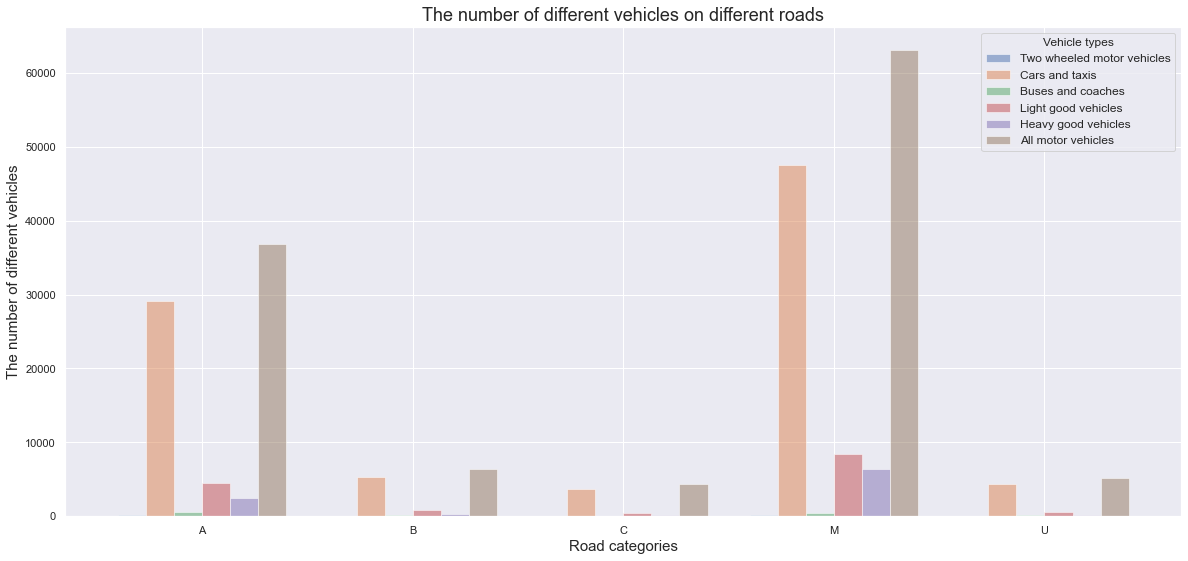

In [7]:
# Select some columns that we need
d = data.loc[:, 'two_wheeled_motor_vehicles':'lgvs']
d[['all_hgvs', 'all_motor_vehicles', 'count_date']] = data.loc[:, ['all_hgvs', 'all_motor_vehicles', 'count_date']]
d['road_categories'] = data['road_name'].str[0]

road_categories = ['M', 'A', 'B', 'C', 'U']

# The distribution of the different types of vehicles on different road (M, A, B, C, U roads)
d.groupby(['road_categories', 'count_date'], as_index = False).sum().groupby('road_categories').mean().sort_values(by = 'road_categories', ascending = True).plot(kind = "bar", figsize = (20, 9), alpha = 0.5, width = 0.8)
plt.xlabel('Road categories', fontsize = 15)
plt.xticks(rotation = 0)
plt.ylabel('The number of different vehicles', fontsize = 15)
plt.title("The number of different vehicles on different roads", fontsize = 18)
plt.legend(title = 'Vehicle types', labels = ['Two wheeled motor vehicles', 'Cars and taxis', 'Buses and coaches', 'Light good vehicles', 'Heavy good vehicles', 'All motor vehicles'], fontsize = 12)
plt.show()

#### 3.2.2 The changes of different vehicles over time.

Secondly, we explore the changes of numbers of different vehicles on different roads over time.

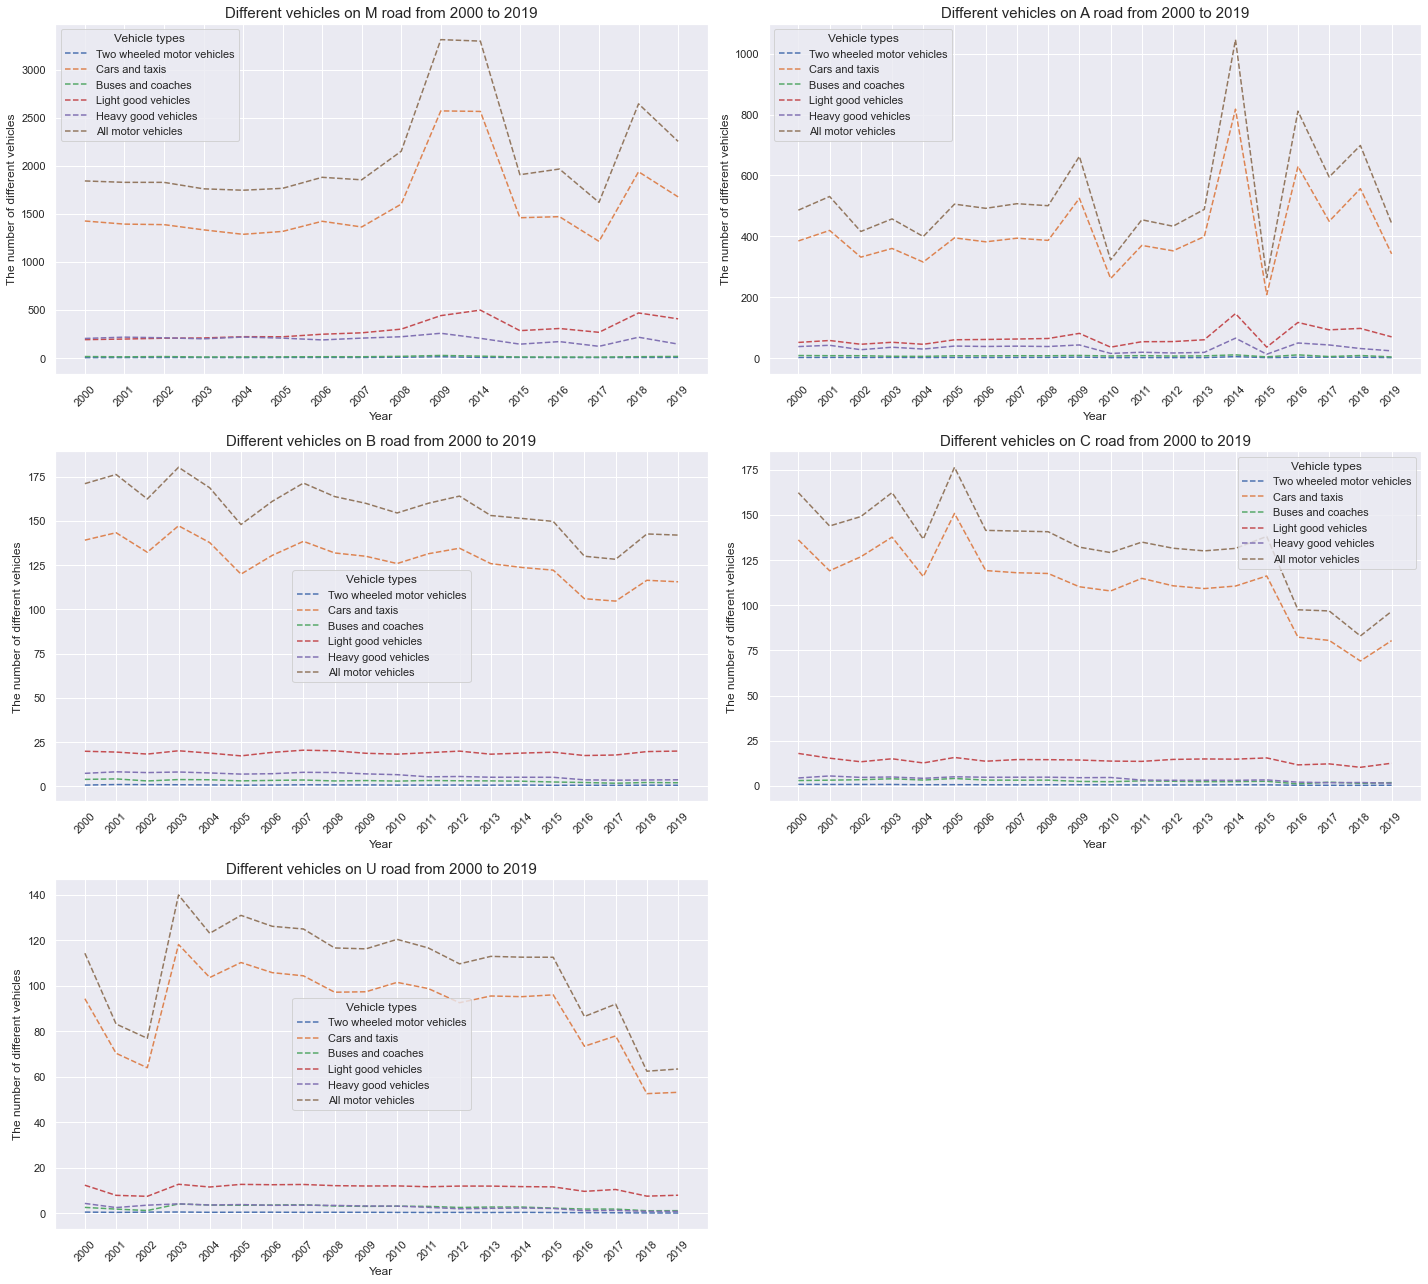

In [8]:
# The change of different types of vehicles on different categories of road (M, A, B, C, U roads) over the years

# Select some columns that we need
d = data.loc[:, 'two_wheeled_motor_vehicles':'lgvs']
d['all_hgvs'] = data.loc[:, 'all_hgvs']
d['all_motor_vehicles'] = data.loc[:, 'all_motor_vehicles']
d['road_categories'] = data.loc[:, 'road_name'].str[0]
d['year'] = data.loc[:, 'year']
road_categories = ['M', 'A', 'B', 'C', 'U']

# Find the number of vehicles on different categories of road (M, A, B, C, U roads) over the years
r = []
for c in road_categories:
    r.append(d.loc[d.road_categories == c, ].groupby('year').mean().sort_values(by = 'year', ascending = True))

# Define the function to draw subgraphs to see the changes over the year
def draw(location_of_subgraph, data, road_categorie):
    ax = fig.add_subplot(location_of_subgraph)
    ax.plot(data, linestyle = 'dashed')
    plt.xlabel('Year', fontsize = 12)
    plt.xticks(rotation = 45)
    plt.ylabel('The number of different vehicles', fontsize = 12)
    plt.title("Different vehicles on " + road_categorie + " road from 2000 to 2019", fontsize = 15)
    plt.legend(title = 'Vehicle types', labels = ['Two wheeled motor vehicles', 'Cars and taxis', 'Buses and coaches', 'Light good vehicles', 'Heavy good vehicles', 'All motor vehicles'])

# Draw the subgraphs
fig = plt.figure(figsize = (20, 18))
for i in range(0, 5):
    draw(321 + i, r[i], road_categories[i])
fig.tight_layout()
plt.show()

According to the bar graph, the number of vehicles passing M Road is the largest. According to the line chart, the number of motor vehicles is the largest on any road, followed by light goods vans and heavy goods vans. Among them, the number of vehicles on the M road has fluctuated greatly since 2008, and reached the maximum number of 7000 in 2014. Similarly, the number of vehicles on Road A has fluctuated greatly since 2008. The number of vehicles on roads B, C, and D showed an overall downward trend, while roads C and U dropped significantly.

### 3.3 The distribution of some vehicles in different cities and changes over time.

Next, we want to use traffic data to explore some more interesting things. We think that the size of the traffic volume can reflect the prosperity of the city to a certain extent, so we will plot the number of cars and taxis in different cities and the number of buses and coaches in different cities respectively.

#### 3.3.1 The distribution of vehicles in different cities.

First, we analyze the distribution of vehicles in different cities.

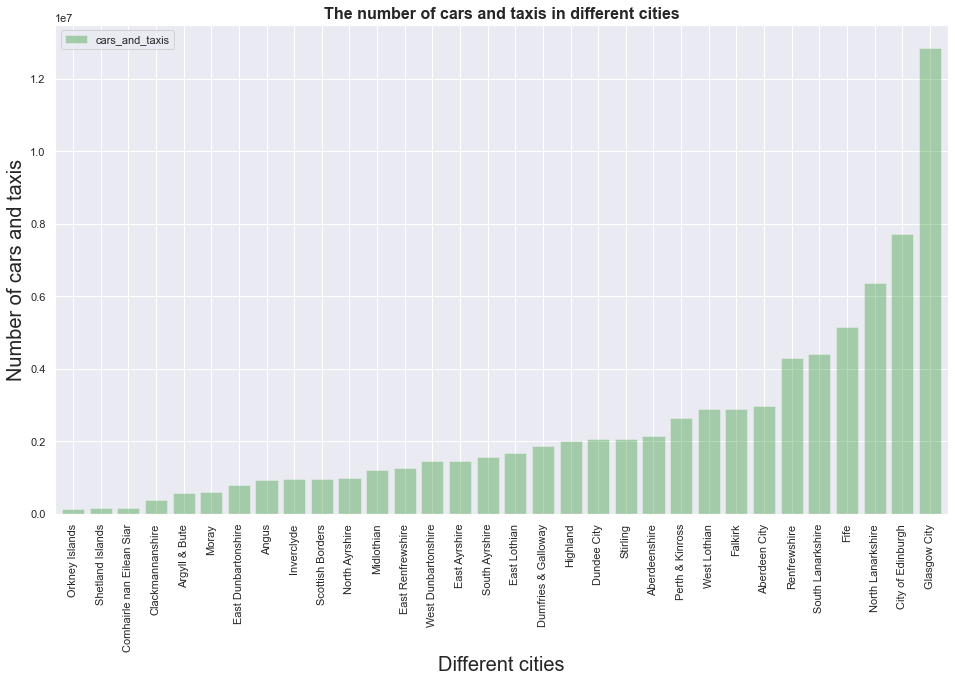

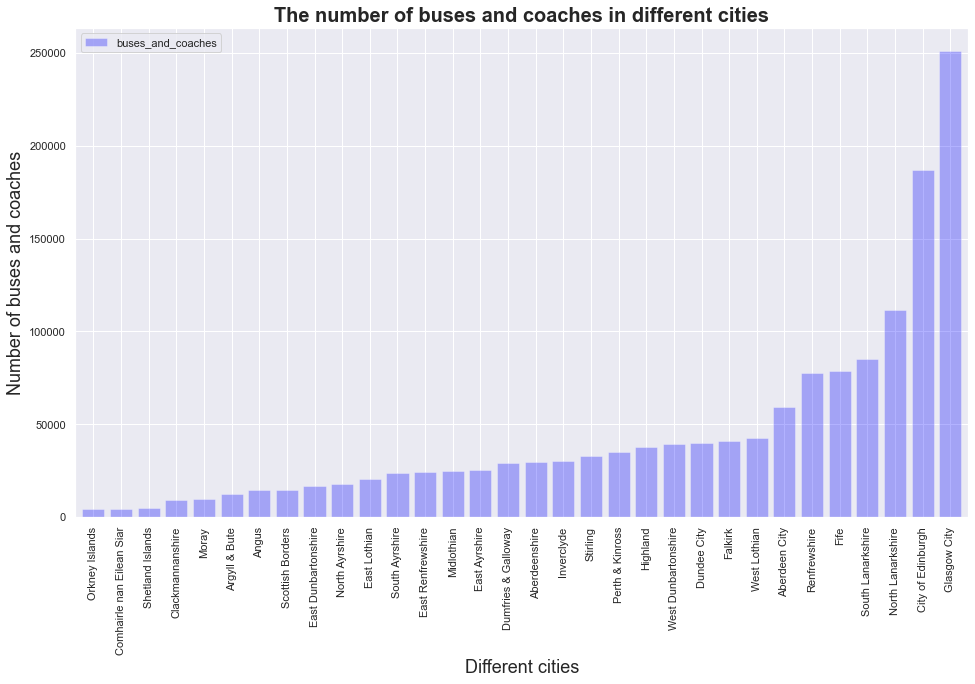

In [9]:
# The number of cars and taxis in different cities (we calculate the number of cars and taxis in different cities)
c = data[['local_authority_name', 'cars_and_taxis']].groupby(['local_authority_name']).sum().sort_values(by = 'cars_and_taxis', ascending = True)

# Draw the picture
c.plot.bar(figsize = (16, 9), color = 'green', alpha = 0.3, width = 0.8)
plt.title('The number of cars and taxis in different cities', fontsize = 16, fontweight = 'bold')
plt.xlabel('Different cities', fontsize = 20)
plt.ylabel('Number of cars and taxis', fontsize = 20)
plt.show()

# The number of buses and coaches in different cities (we calculate the number of buses and coaches in different cities)
b = data[['local_authority_name', 'buses_and_coaches']].groupby(['local_authority_name']).sum().sort_values(by = 'buses_and_coaches', ascending = True)

# Draw the picture
b.plot.bar(figsize = (16, 9), color = 'blue', alpha = 0.3, width = 0.8)
plt.title("The number of buses and coaches in different cities", fontsize = 20, fontweight = "bold")
plt.xlabel('Different cities', fontsize = 18)
plt.ylabel('Number of buses and coaches', fontsize = 18)
plt.show()

The conclusion is in line with our hypothesis. The city with the most cars and taxis and buses and coaches is Glasgow, followed by Edinburgh.

#### 3.3.2 The changes of different vehicles in Edinburgh over time.

Next, we want to know more about the changes of numbers of cars_and_taxis and buses_and_coaches in our favorite city Edinburgh from 2000 to 2019.

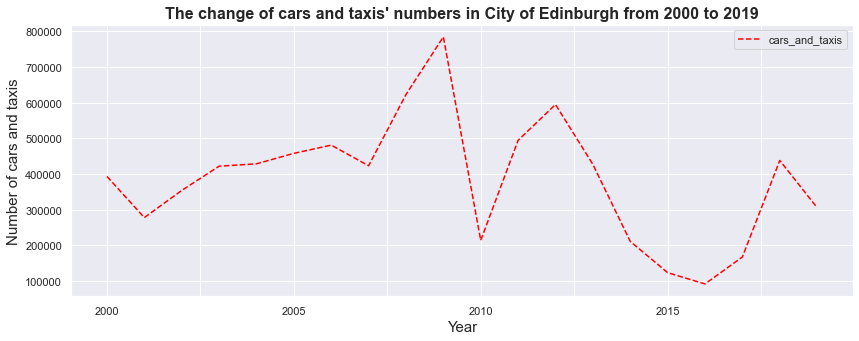

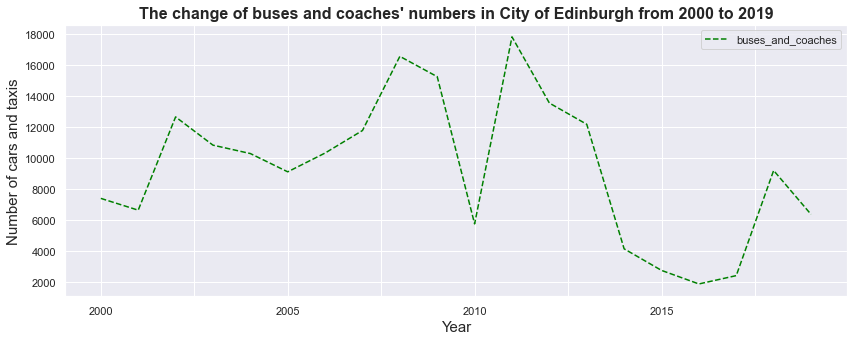

In [10]:
# The change of number of cars and taxis in Edinburgh from 2000 to 2019(We calculate the number of cars and taxis in in Edinburgh from 2000 to 2019)
# Find the data that we need
dr = data[['local_authority_id', 'cars_and_taxis', 'buses_and_coaches']]
dr['year'] = data['year']

# Find that dr.local_authority_id == '29' which means the city of Edinburgh
c = dr.loc[dr.local_authority_id == '29', ['year', 'cars_and_taxis']].groupby(['year']).sum().sort_values(by = 'year')
b = dr.loc[dr.local_authority_id == '29', ['year', 'buses_and_coaches']].groupby(['year']).sum().sort_values(by = 'year')

# Draw the graph
c.plot(figsize = (14, 5), linestyle = 'dashed', color = 'red')
plt.title('The change of cars and taxis\' numbers in City of Edinburgh from 2000 to 2019', fontsize = 16, fontweight = 'bold')
plt.xlabel('Year', fontsize = 15)
plt.ylabel('Number of cars and taxis', fontsize = 15)
plt.show()

b.plot(figsize = (14, 5), linestyle = 'dashed', color = 'green')
plt.title('The change of buses and coaches\' numbers in City of Edinburgh from 2000 to 2019', fontsize = 16, fontweight = 'bold')
plt.xlabel('Year', fontsize = 15)
plt.ylabel('Number of cars and taxis', fontsize = 15)
plt.show()

For cars and taxis, the number of cars and taxis in Edinburgh fluctuated significantly around 400,000. Around 2009, the number reached its peak, nearly 800,000. After that, it experienced the most significant decline, and then the number increased first and then slowly declined, reaching the bottom in 2016.

For buses and coaches, the number of these in Edinburgh fluctuated significantly around 10,000. And the number peaked around 2011, nearly 18,000. And the number of vehicles reached its lowest point around 2015, nearly 2,000.

## 4. Change of traffic statistic with time

In this section, let us analyze the change patterns of traffic statistic with time, including the changes of traffic volumes and the numbers of all types of vechicles during a period of time.

### 4.1 Annual traffic volumes in Scotland

We firstly create the line graph that displays the change tendency of annual traffic volumes by vehicles to have an overall cognition of the traffic status in Scotland. Using the manual count data, we first construct the dataframe that contains the data about total traffic volumes for the whole country every year in vehicle-kilometres and then we implement the visualization of these data using `seaborn` package. From the graph, we can see that the year 2010 is a transitional period. There may be adjustments in the counting work in 2010, so many roads may stop being counted in and after 2010. Consequently, it appears a huge drop of traffic volumes in 2010 in the line graph. The annual traffic volumes of all vehicle types increase gradually with fluctuations in the period before 2010 and basically remain stable after 2010.

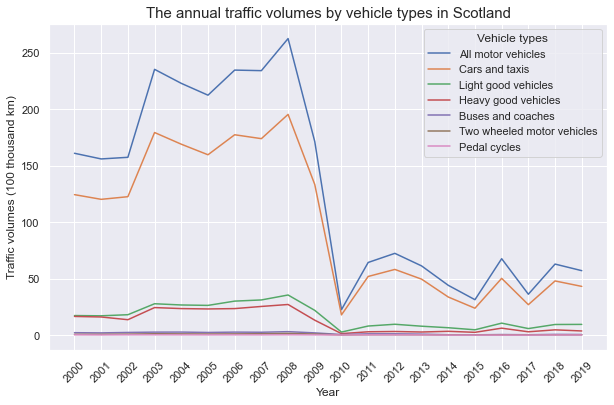

In [11]:
# Create the line graph displaying the change tendency of annual traffic volumes by vehicles in Scotland

# Prepare the data
df = pd.DataFrame({\
'Year' : data['year'],\
'TV_pedal_cycles' : data['pedal_cycles'] * data['link_length_km'],\
'TV_TWMVs' : data['two_wheeled_motor_vehicles'] * data['link_length_km'],\
'TV_cars_and_taxis' : data['cars_and_taxis'] * data['link_length_km'],\
'TV_buses_and_coaches' : data['buses_and_coaches'] * data['link_length_km'],\
'TV_LGVs' : data['lgvs'] * data['link_length_km'],\
'TV_HGVs' : data['all_hgvs'] * data['link_length_km'],\
'TV_all_motor_vehicles' : data['all_motor_vehicles'] * data['link_length_km']})\
.fillna(0).groupby('Year')['TV_pedal_cycles', 'TV_TWMVs', 'TV_cars_and_taxis', 'TV_buses_and_coaches', 'TV_LGVs', 'TV_HGVs', 'TV_all_motor_vehicles'].sum()\
.reset_index().melt(id_vars = 'Year', value_vars = ['TV_pedal_cycles', 'TV_TWMVs', 'TV_cars_and_taxis', 'TV_buses_and_coaches', 'TV_LGVs', 'TV_HGVs', 'TV_all_motor_vehicles'], var_name = 'type', value_name = 'values')
df['values'] /= 100000

# Create the visualization using the Seaborn package
plt.figure(figsize = (10, 6))
sns.lineplot(data = df, x = 'Year', y = 'values', hue = 'type', hue_order = ['TV_all_motor_vehicles', 'TV_cars_and_taxis', 'TV_LGVs', 'TV_HGVs', 'TV_buses_and_coaches', 'TV_TWMVs', 'TV_pedal_cycles'])
plt.xticks(rotation = 45)
plt.xlabel('Year', fontsize = 12)
plt.ylabel('Traffic volumes (100 thousand km)', fontsize = 12)
plt.title('The annual traffic volumes by vehicle types in Scotland', fontsize = 15)
plt.legend(title = 'Vehicle types', labels = ['All motor vehicles', 'Cars and taxis', 'Light good vehicles', 'Heavy good vehicles', 'Buses and coaches', 'Two wheeled motor vehicles', 'Pedal cycles'])

### 4.2 Change patterns of all types of vehicles

Then, we will analyze the change patterns of the numbers of different types vehicles as time to explore the traffic status of Scotland in depth.

On one hand, we calculate the total number of all types of vehicles on each day of the week. We find that the numbers of vehicles of all types except heavy good vans reach the largest on Friday.

In [12]:
# Calculate the total number of all types of vehicles on each day of the week
data[['count_date']].join(data.iloc[:, 19:]).set_index('count_date').groupby(lambda x : time.strftime('%A', time.strptime(x, '%Y-%m-%d'))).sum().reindex(index = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'])

pedal_cycles  two_wheeled_motor_vehicles  cars_and_taxis  \
Monday            52267                       82284        15175685   
Tuesday           49942                       81846        15284765   
Wednesday         46079                       82999        15041281   
Thursday          49346                       84955        14740501   
Friday            54487                      104620        17517496   

           buses_and_coaches     lgvs  hgvs_2_rigid_axle  hgvs_3_rigid_axle  \
Monday                279950  2402880             582869             101081   
Tuesday               283114  2443497             622846             105136   
Wednesday             278352  2424765             610490             103342   
Thursday              272963  2398864             607758             105001   
Friday                321622  2552127             602056             103519   

           hgvs_3_or_4_articulated_axle  hgvs_4_or_more_rigid_axle  \
Monday                            81579                     100127   
Tuesday                           89070                     101124   
Wednesday                         90071                     102507   
Thursday                          89503                     100681   
Friday                            85963                     100712   

           hgvs_5_articulated_axle  hgvs_6_articulated_axle  all_hgvs  \
Monday                      225620                   241119   1332395   
Tuesday                     223317                   224535   1366028   
Wednesday                   231689                   234473   1372572   
Thursday                    231442                   244169   1378554   
Friday                      216187                   216289   1324726   

           all_motor_vehicles  
Monday               19273194  
Tuesday              19459250  
Wednesday            19199969  
Thursday             18875837  
Friday               21820591

On the other hand, we calculate the number of all types of vehicles on each hour of the day. We find that the overall traffic flow is the largest at 17:00 and the least at 10:00. There is a large number of motor vehicles travelling on the road at 8:00, 16:00 and 17:00. The peak period for heavy goods vans is from 8:00 in the morning to 15:00 in the afternoon, during which the number of them is significantly larger than other periods.

In [13]:
# Calculate the number of all types of vehicles on each hour of the day
data[['hour']].join(data.iloc[:, 19:]).astype('int').groupby('hour', as_index = False).sum().sort_values(by = 'hour', ascending = True).set_index('hour')

pedal_cycles  two_wheeled_motor_vehicles  cars_and_taxis  \
hour                                                             
7            25449                       39765         6151622   
8            29892                       37136         7786173   
9            16347                       24456         5577271   
10           13007                       25293         4909306   
11           13748                       28505         5221564   
12           14637                       31627         5675088   
13           14989                       34170         5840216   
14           15379                       35791         6051824   
15           19706                       38931         6816213   
16           27489                       50237         8101479   
17           34643                       52697         8705247   
18           26835                       38096         6923725   

      buses_and_coaches     lgvs  hgvs_2_rigid_axle  hgvs_3_rigid_axle  \
hour                                                                     
7                108429  1304342             256384              50227   
8                143752  1145369             286830              49204   
9                136206  1052444             303651              51050   
10               118171   969941             300440              53063   
11               109289   978461             302752              54986   
12               106596   947148             271369              49123   
13               107749   971965             280767              50939   
14               123697  1034300             293968              51582   
15               141303  1134818             277319              44479   
16               133242  1218366             219553              32355   
17               112693   882715             141533              18909   
18                94874   582264              91453              12162   

      hgvs_3_or_4_articulated_axle  hgvs_4_or_more_rigid_axle  \
hour                                                            
7                            35548                      46855   
8                            39601                      49694   
9                            41286                      50658   
10                           42256                      51246   
11                           43008                      52954   
12                           39753                      45445   
13                           41061                      48483   
14                           40721                      53064   
15                           37733                      47783   
16                           31877                      33942   
17                           24059                      16904   
18                           19283                       8123   

      hgvs_5_articulated_axle  hgvs_6_articulated_axle  all_hgvs  \
hour                                                               
7                       83796                    97985    570795   
8                       89057                    97587    611973   
9                      105752                   108487    660884   
10                     111007                   112155    670167   
11                     113398                   112149    679247   
12                     108580                   107349    621619   
13                     106027                   105233    632510   
14                     104245                   103620    647200   
15                      96011                    97725    601050   
16                      82632                    85077    485436   
17                      69003                    71130    341538   
18                      58747                    62088    251856   

      all_motor_vehicles  
hour                      
7                8174953  
8                9724403  
9                7451261  
10               6692878  
11               7

### 4.3 The number of bicycles

In the last part of this section, we focus on the bicycles and try to explore the change patterns of them.

Fisrtly, we are going to find the change tendency in the number of bicycles during a year to have an overall understanding. We roughly divide every month into four weeks and want to find what are the most likely weeks of a year to find a bicycle anywhere. After the calculation, we can see that the second week of September is the most likely week to find a bicycle. Moreover, it is the least likely to find a bicycle on the second week of July during which only 86 bicycles are counted. Because few roads are counted in November, so we ignore the result of November.

In [14]:
# Define a function to convert the count dates to the weeks of a year
def read_date(date):
    struct_time = time.strptime(date, '%Y-%m-%d')
    mark = 0
    if struct_time.tm_mday <= 7:
        mark = 1
    elif struct_time.tm_mday <= 15:
        mark = 2
    elif struct_time.tm_mday <= 22:
        mark = 3
    else:
        mark = 4
    return '{}-{}'.format(struct_time.tm_mon, mark)

# Calculate the number of bicycles on every week of the year
data[['count_date', 'pedal_cycles']].set_index('count_date').groupby(read_date).sum().sort_values(by = 'pedal_cycles', ascending = False)

pedal_cycles
9-2          19949
5-2          19045
5-3          16967
4-4          16469
6-2          15688
6-4          15654
9-3          13985
6-3          13678
5-1          13144
10-1         13071
9-1          12962
9-4          12133
10-2          9493
5-4           9306
3-4           8582
4-3           8275
6-1           8086
3-3           7141
10-4          5741
4-2           2953
4-1           2691
7-1           2022
10-3          1640
3-2           1323
11-1          1138
8-4            874
7-2             86
11-2            25

Then, we calculate the number of bicycles on U-roads on each day of a week. From the output of the following code chunk, we can see that the number of bicycles on U-roads is the largest on Friday, tightly followed by Monday, and Tuesday has the lowest number of bicycles on U-roads.

In [15]:
# Count the number of bicycles on U-roads on each day of a week
data.loc[data.road_name == 'U', ['count_date', 'pedal_cycles']].set_index('count_date').groupby(lambda x : time.strftime('%A', time.strptime(x, '%Y-%m-%d'))).sum().reindex(index = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'])

pedal_cycles
Monday            14218
Tuesday            7877
Wednesday          9597
Thursday          10141
Friday            14283

Finally, we intend to explore the change of the number of bicycles on C-road every hour of the day. We discover that 17:00 is the most likely time of a day to find a bicycle on a C-road, followed by 8:00, which are just commuter time. Moreover, 11:00 is the time on which the number of bicycles is the least.

In [16]:
# Count the number of bicycles on C-roads at each hour of the day
data.loc[data.road_name == 'C', ['hour', 'pedal_cycles']].groupby('hour', as_index = False).sum().astype('int').sort_values(by = 'hour').set_index('hour')

pedal_cycles
hour              
7             2172
8             3119
9             1786
10            1311
11            1300
12            1493
13            1519
14            1503
15            1964
16            2748
17            3628
18            2928

## 5. Boundary investigation

Below we explore the points on the border between Scotland and England, and hope to examine the trade between the two regions. We use the number of heavy goods vans to represent the frequency of trade.

We get a total of 117 points on the boundary line, and find that the number of heavy goods vans on the date of 2017-10-06 is the largest, reaching 1614, and the number is 0 on 2018-09-21, 2018-06-15, 2018-05-10 and 2018-06-18.

In [17]:
data_new = data[['count_point_id', 'latitude', 'longitude', 'all_hgvs', 'count_date']].groupby(['count_point_id', 'latitude', 'longitude', 'count_date']).sum().reset_index()
df = data_new[['count_point_id', 'latitude', 'longitude']]
df.drop_duplicates(subset = ['count_point_id'], keep = 'first', inplace = True)

# Define distance algorithm
def shortest_distance(latitude, longitude):
    if latitude >= 55.81:
        if longitude >= -2.03:
            distance = np.sqrt((latitude - 55.81) ** 2 + (longitude - (-2.03)) ** 2)
        elif longitude <= -3.0:
            distance = np.sqrt((latitude - 55.81) ** 2 + (longitude - (-3.0)) ** 2)
        else:
            distance = np.abs(latitude - 55.81)
    elif latitude <= 55.0:
        if longitude >= -2.03:
            distance = np.sqrt((55.0 - latitude) ** 2 + (longitude - (-2.03)) ** 2)
        elif longitude <= -3.0:
            distance = np.sqrt((55.0 - latitude) ** 2 + (longitude - (-3.0)) ** 2)
        else:
            distance = np.abs(55.0 - latitude)
    else:
        if longitude >= -2.03:
            distance = np.abs(longitude - (-2.03))
        elif longitude <= -3.0:
            distance = np.abs(longitude - (-3.0))
        else:
            distance = 0
    return distance

dis = []
for index, row in df.iterrows():
    dis.append(shortest_distance(row["latitude"], row["longitude"]))
df['distance'] = dis
min_dis_df = df[df['distance'] == 0]
print('Print the result corresponding to the minimum distance of 0')
display(min_dis_df)

result = []
for index, row in min_dis_df.iterrows():
    re = data_new[data_new['count_point_id'] == row['count_point_id']]
    result.append(re)
result = pd.concat(result)
print('Print the number of heavy goods vehicles cross the border every day')
result[['all_hgvs', 'count_date']].groupby(['count_date']).sum().sort_values(by = 'all_hgvs', ascending = True)

Print the result corresponding to the minimum distance of 0


count_point_id   latitude  longitude  distance
137             1062  55.486623  -2.621872       0.0
154             1069  55.591158  -2.867874       0.0
180            10715  55.734428  -2.899717       0.0
182            10716  55.551804  -2.841645       0.0
183            10717  55.417270  -2.804027       0.0
...              ...        ...        ...       ...
10065         982062  55.417361  -2.789812       0.0
10704         990384  55.605829  -2.670265       0.0
11031         991220  55.666841  -2.268458       0.0
11273         996524  55.469975  -2.635071       0.0
11330         996618  55.621664  -2.363008       0.0

[117 rows x 4 columns]

Print the number of heavy goods vehicles cross the border every day


all_hgvs
count_date          
2018-09-21         0
2018-06-18         0
2018-06-15         0
2018-05-10         0
2019-09-27         1
...              ...
2006-09-27      1047
2008-09-25      1107
2005-04-22      1143
2000-09-06      1215
2017-10-06      1614

[312 rows x 1 columns]

## 6. Visualization of maps

In this part, we use the data 'count_point_id', 'local_authority_name', 'road_name', 'road_type', 'latitude', 'longitude' to create a visulization map in order to observe intuitively the distribution of roads. In general, all kinds of roads, including major roads and minor roads, are mostly distributed in the center of the city. Another characteristic is that other road sections are distributed in an umbrella shape with the city center as the center. As we zoom in on this map, we see that the minor roads are scattered around the main roads, wrapping them around the main roads.

In [18]:
# The map one: Mark all the check points on the map

# Prepare the data
# We have noticed that the coordinate (latitude, longitude) of the check points may be slightly changed as the years, so we take the newest coordinate which is the coordinate in the most recent year for every check point and the next map visualization is also operated in this way.
mark_map_data = data[['count_point_id', 'local_authority_name', 'road_name', 'road_type', 'latitude', 'longitude']].groupby('count_point_id').aggregate({'local_authority_name' : lambda x : x.drop_duplicates(), 'road_name' : lambda x : x.drop_duplicates(), 'road_type' : lambda x : x.drop_duplicates(), 'latitude' : lambda x : x.head(1), 'longitude' : lambda x : x.head(1)}).reset_index()
# Create the map and set the initial location to Edinburgh
latitude = 55.95
longitude = -3.2167
mark_map = folium.Map(location = [latitude, longitude], zoom_start = 12)

# Load the information of check points to the variable that is used to store the features of the map
count_points = plugins.MarkerCluster()
# We use a yellow-blue circle to represent every minor check point, and use a red raindrop-like marker to represent every major check point with the information of the road, the road name, count point ID and local authority name, attached to it
for line in mark_map_data.values:
    if line[3] == 'Minor':
        count_points.add_child(
            folium.CircleMarker(
                [line[-2], line[-1]],
                radius = 5,
                color = 'yellow',
                fill = True,
                fill_color = 'blue',
                fill_opacity = 0.5
            )
        )
    if line[3] == 'Major':
        count_points.add_child(
            folium.Marker(
                [line[-2], line[-1]],
                popup = folium.Popup('{}, ID: {}, {}'.format(line[2], line[0], line[1]), max_width = 1000),
                tooltip = "Click here",
                icon = folium.Icon(color = 'red')
            )
        )

# Add the information of the check points to the original map
mark_map = mark_map.add_child(count_points)
# Display the map
display(mark_map)

Finally, we use the daily average traffic flows of Scotland to observe how busy every area. From the map, we can see intuitively that the areas with heavy traffic flows are mostly distributed in the traffic junction, which is the intersection of several roads. Combined with the road marking map above, we can conclude that the main roads are much busier than the minor roads.

In [19]:
# The map two: Create the heat map of the daily average traffic flows for Scotland

# Initialize the data that will be used to create the heat map
heat_map_data = data[['count_point_id', 'year', 'latitude', 'longitude']]
heat_map_data['cars_num'] = data['pedal_cycles'] + data['all_motor_vehicles']

# Prepare the data of the daily average traffic flows at every check point
heat_map_data = heat_map_data.groupby(['count_point_id', 'year']).aggregate({'latitude' : lambda x : x.drop_duplicates(), 'longitude' : lambda x : x.drop_duplicates(), 'cars_num' : sum}).reset_index().groupby('count_point_id').aggregate({'latitude' : lambda x : x.tail(1), 'longitude' : lambda x : x.tail(1), 'cars_num' : lambda x : x.mean()/245})

# Convert the data to the necessary format to suit the function HeatMap() which is specifically used to create heat maps
heat_map_data = heat_map_data.values.tolist()

# Create and display the heat map
heat_map = folium.Map(location = [latitude, longitude], zoom_start = 12)
plugins.HeatMap(heat_map_data).add_to(heat_map)
display(heat_map)